# DenseNet의 구조

https://csm-kr.tistory.com/10

https://beginnerdeveloper-lit.tistory.com/162

https://arxiv.org/pdf/1608.06993.pdf

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

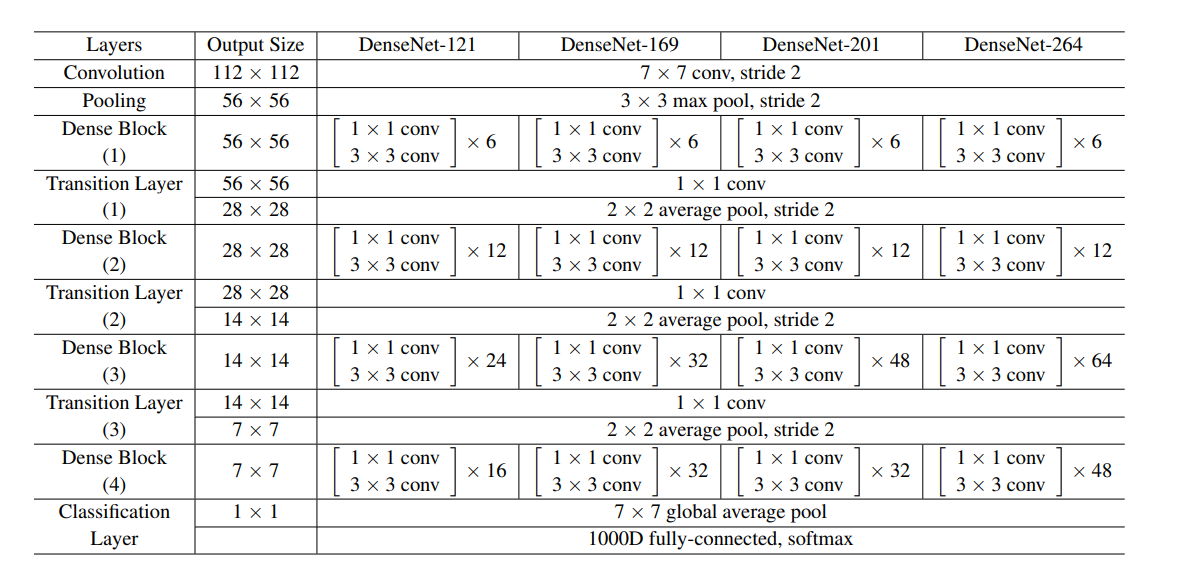

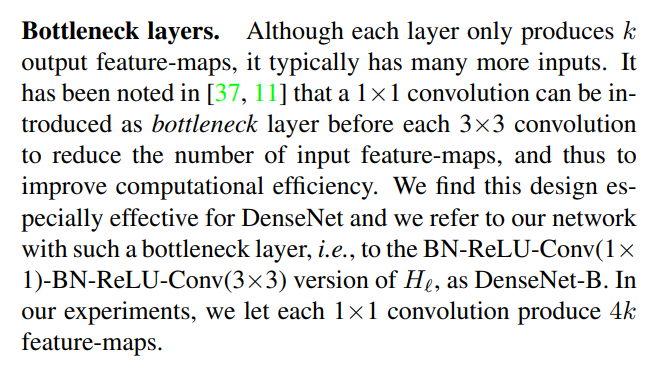

In [22]:
class DenseLayer(nn.Module):

    def __init__(self, in_channel, growth_rate):

        super(DenseLayer, self).__init__()

        self.batch_norm1 = nn.BatchNorm2d(in_channel)
        self.conv_layer1 = nn.Conv2d(in_channels = in_channel, out_channels = 4*growth_rate, kernel_size = 1, bias = False)
        self.batch_norm2 = nn.BatchNorm2d(4*growth_rate)
        self.conv_layer2 = nn.Conv2d(in_channels = 4*growth_rate, out_channels = growth_rate, kernel_size = 3, padding = 1, bias = False)

    #BN > RELU > CONV > BN > RELU > CONV
    def forward(self, x):

        x1 = self.conv_layer1(F.relu(self.batch_norm1(x)))
        x1 = self.conv_layer2(F.relu(self.batch_norm2(x1)))

        x1 = torch.cat([x,x1],1)

        return x1

In [40]:
class DenseBlock(nn.Module):

    def __init__(self, growth_rate, rate, num):

        super(DenseBlock, self).__init__()

        self.layers = []

        for i in range(rate,rate+num):

            self.layers.append(DenseLayer(i*growth_rate,growth_rate))

        self.block = nn.Sequential(*self.layers) #torch.cat[torch.cat[x,x1],y1] = torch.cat[x,x1,y1]

    def forward(self,x):

        return self.block(x)

In [23]:
class TransitionBlock(nn.Module):

    def __init__(self, in_channel, out_channel):

        super(TransitionBlock, self).__init__()

        self.batch_norm = nn.BatchNorm2d(in_channel)
        self.conv_layer = nn.Conv2d(in_channels = in_channel, out_channels = out_channel, kernel_size = 1, bias = False)

    def forward(self, inp):

        op = self.conv_layer(F.relu(self.batch_norm(inp)))
        op = F.avg_pool2d(op, 2)

        return op

In [99]:
class DenseNet121(nn.Module):

    def __init__(self, in_channel = 3, growth_rate = 32, num_classes = 1000): #in_channel = 3은 이미지의 channel이 보통 RGB로 3개니까

        super(DenseNet121,self).__init__()

        self.growth_rate = growth_rate
        self.compression = 2

        #out_channel은 설정한 growth_rate 값에 따라 달라짐

        self.conv = nn.Conv2d(in_channel,2*self.growth_rate,kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.batch_norm = nn.BatchNorm2d(2*self.growth_rate)
        self.pooling = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1) #padding을 안주면 64*55*55로 나와서 꼬이더라...

        self.dense_block1 = DenseBlock(self.growth_rate, 2, 6)
        self.transition_layer1 = TransitionBlock(8*self.growth_rate,8*self.growth_rate//self.compression)

        self.dense_block2 = DenseBlock(self.growth_rate, 4, 12)
        self.transition_layer2 = TransitionBlock(16*self.growth_rate,16*self.growth_rate//self.compression)

        self.dense_block3 = DenseBlock(self.growth_rate, 8, 24)
        self.transition_layer3 = TransitionBlock(32*self.growth_rate, 32*self.growth_rate//self.compression)

        self.dense_block4 = DenseBlock(self.growth_rate, 16, 16)

        self.global_pooling = nn.AvgPool2d(kernel_size = 7)
        #self.batch_norm2 = nn.BatchNorm2d(32*self.growth_rate)

        #마지막에 classifier layer에 넣기 전에 feature map을 flatten으로 vector로 만들고 넣어줘야
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(in_features = 32*self.growth_rate, out_features = num_classes, bias = False)

    def forward(self, x):

        #layer를 만들기 전에 각 output의 shape를 확인하면서, in_channel, out_channel들을 적당히 설정

        x = self.pooling(F.relu(self.batch_norm(self.conv(x)))) #64*56*56

        x = self.dense_block1(x) #256*56*56
        x = self.transition_layer1(x) #128*28*28

        x = self.dense_block2(x) #512*28*28
        x = self.transition_layer2(x) #256*14*14

        x = self.dense_block3(x) #1024*14*14
        x = self.transition_layer3(x) #512*7*7

        x = self.dense_block4(x) #1024*7*7

        x = self.global_pooling(x) #1024*1*1

        x = self.flatten(x) #1*1024
        x = self.classifier(x) #1*1000

        return x


In [103]:
densenet = DenseNet121(growth_rate = 12)

x = torch.rand((3,224,224))

y = densenet(x.unsqueeze(0))

print(y.shape)


torch.Size([1, 1000])


# torchvision library

In [1]:
from torchvision.models import densenet121

model = densenet121()

In [2]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [94]:
model(x.unsqueeze(0)).shape

torch.Size([1, 1000])